In [3]:
import requests
import warnings
import pickle
import time
import json
from tqdm import tqdm
from functools import wraps
from datetime import datetime
from typing import Dict, List, Union, Callable, Any, Optional


In [4]:
access_token = '*****'
api_v = '5.130'

In [5]:
class VKMutual:
    def __init__(self, token, v):
        self.token = token
        self.v = v
        self.friends = self.get_friends()
        
    def get_req(self, method, parameters):
        return requests.get('https://api.vk.com/method/%s?%s&access_token=%s' % (method, '&'.join(parameters),\
                                                                                 self.token)).json()

    def get_friends(self):
        method = 'friends.get'
        data = self.get_req(method, [f'v={self.v}'])
        friends = data['response']['items']
        return friends
    
    def get_mutual_friends(self):
        my_id = '51605976'
        mutual = {}
        for i in self.friends:
            x = (self.get_req('friends.getMutual', ['order=hints',\
                                          'target_uid=%s' % i, f'v={self.v}']))
            try:
                mutual[i] = x['response']
            except:
                continue
        
            time.sleep(2)
        
        return mutual

In [6]:
a = VKMutual(access_token, api_v)
mutual = a.get_mutual_friends()

In [130]:
mutual

{557323: [182122064,
  230582966,
  108544312,
  135031641,
  104333070,
  105481878,
  128406321,
  174075483,
  181236046,
  186838622,
  210586647,
  238527831,
  267489582,
  328751017,
  356272769,
  420038528],
 1980620: [45709159],
 2505434: [148242223,
  53234251,
  94071220,
  100448022,
  197506792,
  243673333,
  280138377,
  386811908,
  488592493,
  542111960,
  626749945],
 2946620: [283926364,
  64682317,
  81513117,
  100722044,
  145751440,
  180525885,
  188879711,
  215247545,
  273845369,
  295747361,
  451576380],
 4183016: [148242223,
  338305603,
  4707571,
  12705330,
  45709159,
  86476650,
  94071220,
  164881284,
  203392078,
  283606830,
  542111960],
 4707571: [148242223,
  338305603,
  4183016,
  12705330,
  45709159,
  86476650,
  94071220,
  164881284,
  203392078,
  283606830,
  542111960],
 10341755: [148242223, 139068288],
 11204976: [182122064,
  136523605,
  28048753,
  102954811,
  135384448,
  144816537,
  162522461,
  187013781,
  197663867,
  33

In [150]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
import math


class Graph:
    def __init__(self, dictG):
        self.dictG = dictG
        self.G = self.get_nx_G()
    
    def get_nx_G(self):
        G = nx.Graph()
        new_dict = {k: v for k, v in self.dictG.items() if len(v) != 0}
                
        for node in new_dict:
            G.add_node(node)
            for neighbor in new_dict[node]:
                G.add_edge(node, neighbor)
        return G
    
    def plot_G(self):
        plt.figure(figsize=(25, 17))
        layout = nx.spring_layout(self.G)
        nx.draw_networkx(self.G, pos=layout, node_size=10)
    
    def base_info(self):
        print(f'Connected? {nx.is_connected(self.G)}')
        print(f'Radius: {nx.radius(self.G)}')
        print(f'Diameter: {nx.diameter(self.G)}')
        print(f'Average shortest path length: {nx.average_shortest_path_length(self.G)}')
        print(f'Average clustering coefficient: {nx.average_clustering(self.G)}')
        print(f'Number of nodes and edges: {nx.info(self.G)}')
    
    def avg_path_len(self, n_nodes=np.arange(1, 280, 10)):
        avg_path_len = np.array([]) 
        for n in n_nodes:
            large_cc = max(nx.connected_components(self.G), key=len)
            g_l_cc = self.G.subgraph(large_cc).copy()
            avg_path_len = np.append(avg_path_len, nx.average_shortest_path_length(g_l_cc))
        plt.plot(n_nodes, avg_path_len)
        plt.xlabel('N')
        plt.ylabel('Average path length')
        plt.show()
    
    @staticmethod
    def power_law_pdf(x, alpha=3.5, x_min=1):
        C = (alpha - 1) / x_min ** (1 - alpha)
        return C * x ** (-alpha)
    
    @staticmethod
    def power_law_cdf(x, alpha=3.5, x_min=1):
        C = (alpha - 1) / x_min ** (1 - alpha)
        return 1 - C * ((x**(1-alpha))/(alpha-1))
    
    def mle_power_law_params(self):
        degree_sequence = [d for n, d in self.G.degree()]
        alphas = 0
        x_mins = 0
        ksd = []
        x_min = math.floor(min(degree_sequence))
        x_max = math.ceil(max(degree_sequence))
        ds = np.sort(degree_sequence)
        check = float('inf')
    #     print(x_min, x_max)
        for i in range(x_min, x_max):
            ds = ds[ds >= i]
            if len(ds) < 1:
                break
            else:
                alpha = len(ds) / np.log(ds / i).sum() + 1
                res, _ = kstest(ds, cdf=lambda x : power_law_cdf(x, alpha, x_min))
                ksd.append(res)
                if check > res:
                    check = res
                    x_mins = i
                    alphas = alpha
        #     print(alphas, x_mins)
        return alphas, x_mins
    
    def plot_dist(self):
        degree_sequence = [d for n, d in self.G.degree()]
        hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
        hat_alpha, hat_x_min = self.mle_power_law_params()
        x_space = np.linspace(hat_x_min, degree_sequence.max(), 100)
        plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
                 label='Estimated PDF', c='tab:orange')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim(0.001, 0.5)



In [151]:
Gr = Graph(mutual)
Gr.base_info()

Directed? True
Radius: 4
Diameter: 7
Average shortest path length: 2.975336444540916
Average clustering coefficient: 0.5667456781789819
Number of nodes and edges: Graph with 272 nodes and 2229 edges
[557323, 182122064, 230582966, 108544312, 135031641, 104333070, 105481878, 128406321, 174075483, 181236046, 186838622, 210586647, 238527831, 267489582, 328751017, 356272769, 420038528, 1980620, 45709159, 2505434, 148242223, 53234251, 94071220, 100448022, 197506792, 243673333, 280138377, 386811908, 488592493, 542111960, 626749945, 2946620, 283926364, 64682317, 81513117, 100722044, 145751440, 180525885, 188879711, 215247545, 273845369, 295747361, 451576380, 4183016, 338305603, 4707571, 12705330, 86476650, 164881284, 203392078, 283606830, 10341755, 139068288, 11204976, 136523605, 28048753, 102954811, 135384448, 144816537, 162522461, 187013781, 197663867, 335318849, 480409599, 559434592, 11918233, 131483744, 136117534, 152241559, 184168041, 491873587, 155155314, 194524276, 19736323, 332716051, 

C:\Users\balzh\AppData\Local\Temp\ipykernel_2016\3230638373.py:34: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f'Number of nodes and edges: {nx.info(self.G)}')


In [108]:
import pandas as pd


class StructAnalysis(Graph):
    def __init__(self, dictG):
        super().__init__(dictG)
        self.G = self.get_nx_G()
        self.pos = nx.kamada_kawai_layout(self.G)
        
    def centralities(self):
        return {
            "degree": np.array(list(nx.degree_centrality(self.G).values())),
            "closeness": np.array(list(nx.closeness_centrality(self.G).values())),
            "betweenness": np.array(list(nx.betweenness_centrality(self.G).values()))
        }
    def top10_centralities(self):
        r = {}
        for n, f in zip(["degree", "betweenness", "closeness"],[nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality]):
            sort = sorted(list(f(self.G).items()), key=lambda x:x[1], reverse=True)
            ids, centrality = zip(*sort)
            friend_id = [y for y in ids]
            r[n] = pd.DataFrame({"id": friend_id, "centrality": centrality})
        return r
    
    def plot_centralities(self):
        c = self.centralities()
        top_dfs = self.top10_centralities()
        cases = [['degree', 5000, 0, 'Degree centrality'], 
                 ['closeness', 700, 0, 'Closeness centrality'],
                 ['betweenness', 900, 20, 'Betweenness centrality']]
        for c_key, scale, bias, title in cases:
            print(title)
            display(top_dfs[c_key])
            plt.figure(figsize=(10, 8))
            nx.draw(self.G, 
                    self.pos,
                    width=0.5,
                    linewidths=0.5,
                    edgecolors='black',
                    cmap=plt.cm.hot,
                    node_size=c[c_key]*scale + bias,
                    node_color=c[c_key])
            plt.show()
        
    def katz_centrality(self, n=1, beta=1/30):
        A = nx.to_numpy_array(self.G)
        if beta >= 1 / max(np.linalg.eigvals(A)):
            raise Exception('Error')

        k_centrality = np.zeros(len(A))

        for i in range(1, n+1):
            k_centrality += beta**i * np.linalg.matrix_power(A, i).sum(axis=1)
        
        return k_centrality
    
    def plot_katz_centrality(self):
        k_centrality = self.katz_centrality()
        k_centrality = k_centrality / k_centrality.max()
        plt.figure(figsize=(8, 6))
        nx.draw(self.G, 
                self.pos,
                width=0.5,
                linewidths=0.5,
                edgecolors='black',
                cmap=plt.cm.hot,
                node_size=k_centrality*300,
                node_color=k_centrality)
        plt.show()
        
    
    def eigenvector_centrality(self):
        A = nx.to_numpy_array(self.G)
        w, v = np.linalg.eig(A)
        eig_c = abs(v[:, np.argmax(w)])
        return eig_c
    
    def plot_eigenvector_centrality(self):
        eig_c = self.eigenvector_centrality()
        plt.figure(figsize=(8, 6))
        nx.draw(self.G, 
                self.pos,
                width=0.5,
                linewidths=0.5,
                edgecolors='black',
                cmap=plt.cm.hot,
                node_size=eig_c/eig_c.max()*400,
                node_color=eig_c)
        plt.show()
        
        
    def pearson_correlation(self):
        centvals = [
            ('Degree', list(nx.degree_centrality(self.G).values())),
            ('Closeness', list(nx.closeness_centrality(self.G).values())),
            ('Betweenness', list(nx.betweenness_centrality(self.G).values())),
            ('Katz', self.katz_centrality()), 
            ('Eigenvector', self.eigenvector_centrality())
        ]
        plt.figure(figsize=(2*5, 5*5))
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        k = 1
        for i in range(len(centvals)):
            for j in range(i + 1, len(centvals)):
                i_label, i_vals = centvals[i]
                j_label, j_vals = centvals[j]
                correlation = np.corrcoef(i_vals, j_vals)[0][1]
                plt.subplot(5, 2, k)
                plt.scatter(i_vals, j_vals, s=5)
                plt.title('Correlation: {:.4f}'.format(correlation))
                plt.xlabel(i_label)
                plt.ylabel(j_label)
                k += 1
                
    def page_rank(self, alpha=0.8, k=20):
        A = nx.to_numpy_array(self.G)
        P = transition_matrix(A)
        v = teleportation_vector(A)
        rank = np.ones(A.shape[0]) / A.shape[0]
        for _ in range(k):
            rank = update_rank(rank, P, v, alpha)
        return np.array(rank)

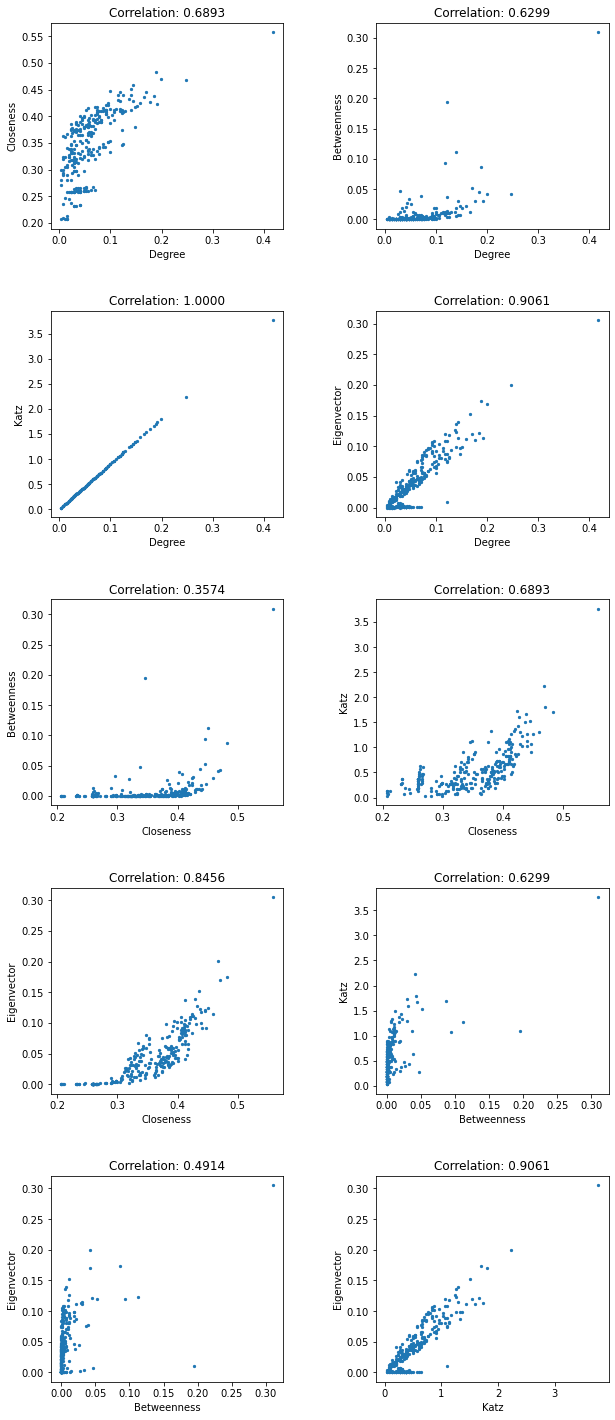

In [109]:
Gr = Graph(mutual)
siuu = StructAnalysis(mutual)
a = siuu.pearson_correlation()

In [210]:
class CommunityDetection(Graph):
    def __init__(self, dictG):
        super().__init__(dictG)
        self.G = self.get_nx_G()
        self.lesG = nx.convert_node_labels_to_integers(self.G)
        self.pos = nx.kamada_kawai_layout(self.lesG)
        
    @staticmethod
    def k_core_decompose(G):
        return np.array(list(nx.core_number(G).values()))
    
    def k_core_visualization(self):
        plt.figure(figsize=(8*2, 8*4))
        x_max, y_max = np.array(list(self.pos.values())).max(axis=0)
        x_min, y_min = np.array(list(self.pos.values())).min(axis=0)
        for i in range(8):
            plt.subplot(4, 2, i+1)
            subG = nx.k_core(self.lesG, i+1)
            nodes = nx.draw_networkx_nodes(
                subG, 
                self.pos,
                cmap=plt.cm.OrRd,
                node_color=self.k_core_decompose(subG), 
                node_size=100, 
                edgecolors='black'
            )
            nx.draw_networkx_edges(
                subG, 
                self.pos,
                alpha=0.3,
                width=1, 
                edge_color='black'
            )
            eps = (x_max - x_min) * 0.05
            plt.xlim(x_min-eps, x_max+eps)
            plt.ylim(y_min-eps, y_max+eps)
            plt.legend(*nodes.legend_elements())
            plt.axis('off')
            plt.title('k-shells on {}-core'.format(i+1))

    @staticmethod
    def color_clique(G, max_cliques):
        start_end_colors = [np.array([255/255, 204/255, 229/255]), np.array([77/255, 0, 36/255])]
        step_color = [(x - y)/(len(max_cliques)-1) for x, y in zip(start_end_colors[1], start_end_colors[0])]

        colors_cliques = []
        color = start_end_colors[0]

        for clique in max_cliques:
            clique_color = []
            for node in G.nodes():
                if node in clique:
                    clique_color.append(color)
                else:
                    clique_color.append([1, 1, 1])
            colors_cliques.append(clique_color)
            color = start_end_colors[1]

        return np.array(colors_cliques)

    @staticmethod
    def edge_width(G, max_cliques):
        edges_width = []

        for clique in max_cliques:
            clique_width = []
            for edge in G.edges():
                if edge[0] in clique and edge[1] in clique:
                    clique_width.append(1.5)
                else:
                    clique_width.append(0.5)
            edges_width.append(clique_width)

        return np.array(edges_width)
    
    def largest_cliques(self):
        cliques_list = list(nx.find_cliques(self.lesG))
        max_cliques = [clique for clique in cliques_list if len(clique) == len(max(cliques_list, key=lambda x:len(x)))]
        colors_cliques = self.color_clique(self.lesG, max_cliques)
        edges_width = self.edge_width(self.lesG, max_cliques)
        return colors_cliques, edges_width
    
    def clique_visualization(self):
        colors, widths = self.largest_cliques()
        size = np.unique(colors[0], axis=0, return_counts=True)[1][0]
        plt.figure(figsize=(8*3, 8*6))
        for i in range(colors.shape[0]):
            b_edges = np.array(list(self.lesG.edges))[widths[i] == widths[i].max()]
            plt.subplot(i+2, 2, i+1)
            nodes = nx.draw_networkx_nodes(
                self.lesG, 
                self.pos,
                node_color=colors[i], 
                node_size=120, 
                linewidths=1, 
                edgecolors='black'
            )
            nx.draw_networkx_edges(
                self.lesG,
                self.pos,
                alpha=0.3,
                width=widths[i].min()
            )
            nx.draw_networkx_edges(
                self.lesG,
                self.pos,
                width=widths[i].max(),
                edgelist=b_edges
            )
            plt.title('Clique of the size {}'.format(size))
            plt.axis('off')

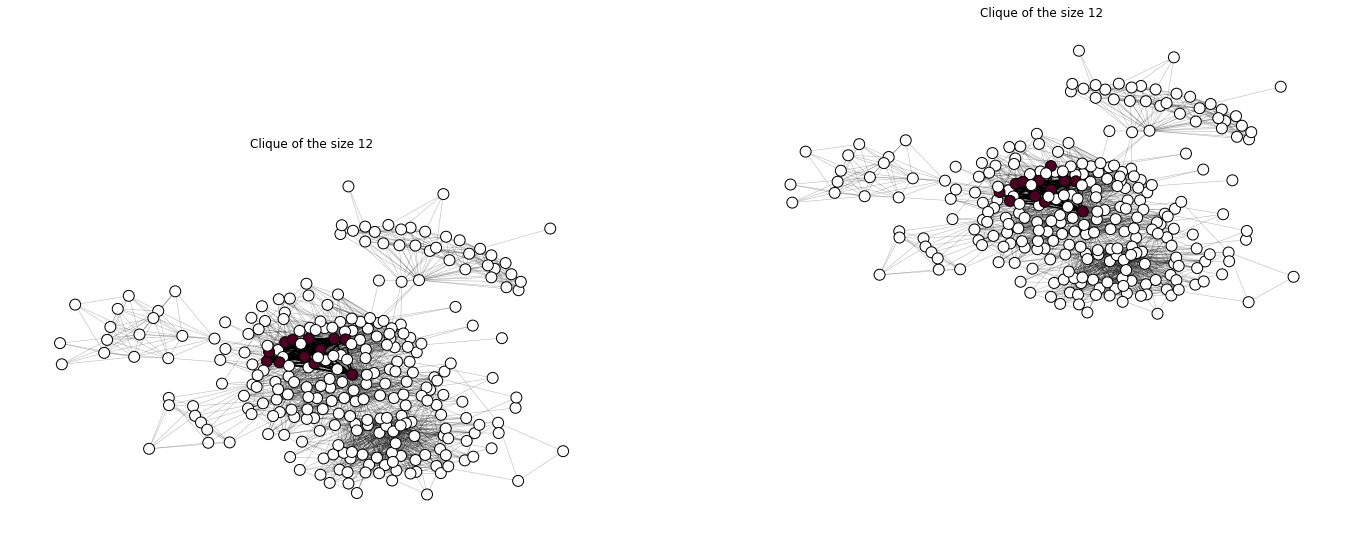

In [211]:
siuu = CommunityDetection(mutual)
a = siuu.clique_visualization()